In [1]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
# Load used training data

filepath = '../data/intermediate/experimentation_train_sets/'

filename = 'train_b_493_m_0_sm_n_t_20200206_193734.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8630 entries, 2016-01-01 23:00:00 to 2016-12-31 23:00:00
Data columns (total 7 columns):
day_of_week               8630 non-null int64
day_hour                  8630 non-null int64
dew_temperature_ma_24H    8630 non-null float64
dew_temperature           8630 non-null float64
air_temperature_ma_24H    8630 non-null float64
air_temperature           8630 non-null float64
meter_reading             8630 non-null float64
dtypes: float64(5), int64(2)
memory usage: 539.4 KB


In [3]:
# Build a copy of the train dataset but with 'full index', 
# ie index containing all the hours of the year 2016.

full_date_range = pd.date_range(start='2016-01-01 00:00:00', end='2016-12-31 23:00:00', freq='H')
full_index = pd.DatetimeIndex(full_date_range)

df_full = pd.DataFrame(index=full_index)
for col_name in df_features.columns:
    df_full[col_name] = df_features[col_name]
    
df_full.head(30)

,day_of_week,day_hour,dew_temperature_ma_24H,dew_temperature,air_temperature_ma_24H,air_temperature,meter_reading
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_to_draw = df_full.copy()
data_to_draw['day_hour'] = data_to_draw.index.to_series().dt.hour
data_to_draw['day_of_week'] = data_to_draw.index.to_series().dt.dayofweek
data_to_draw['day_of_year'] = data_to_draw.index.to_series().dt.dayofyear
data_to_draw['week_of_year'] = data_to_draw.index.to_series().dt.week.mod(53)

In [5]:
df_w1 = data_to_draw[['day_of_year', 'day_hour', 'meter_reading']].copy()
df_w1.reset_index(drop=True, inplace=True)
#df_w1.set_index(['day_of_week'], inplace=True)
df_w1_piv = df_w1.pivot(index='day_of_year', columns='day_hour', values='meter_reading')
df_w1_piv.head()

day_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_year,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316.17
2,297.51,294.78,296.94,294.63,309.42,312.72,380.97,373.38,393.03,397.05,...,345.69,294.48,343.08,350.37,331.68,323.82,325.05,331.20,326.07,284.58
3,295.32,299.25,290.43,296.43,298.74,299.22,373.20,371.49,364.14,357.69,...,311.82,267.18,289.32,313.41,294.84,316.98,322.74,330.09,316.95,296.94
4,301.26,299.13,298.92,297.51,296.94,298.62,400.95,590.88,614.31,564.12,...,370.98,439.29,500.52,501.75,510.54,510.75,496.44,514.89,475.29,332.37
5,308.97,308.61,425.10,428.76,421.41,433.83,467.22,649.35,684.60,645.54,...,455.25,509.40,557.61,552.18,555.12,562.26,495.42,474.27,471.54,299.07


<b>Visualize meter_reading missing datas after train set cleaning.</b><br>
<br>
Those are final meter_reading values used for training, after naïve cleaning.<br>
i.e. :<br>
Any row of the dataset containing a missing value for any feature will be translated by a missing_value.

In [8]:
# Set nan values in red
plt.get_cmap('Blues').set_bad('#ea0c0c')

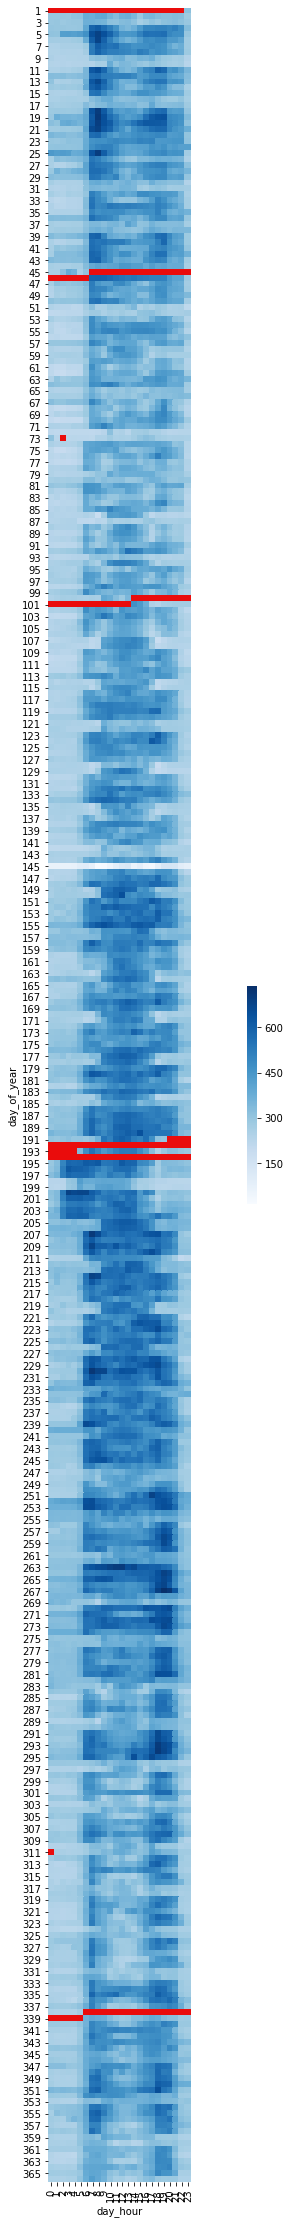

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,40))
sns.heatmap(df_w1_piv, cmap='Blues', cbar_kws={"shrink": 0.1}, square=True, ax=ax)

<b>Entry data</b>

In [12]:
data_folder_path = '../data/raw/csvs/'
this_building = 493
this_meter = 0

# Loads building_metadata to get site-building mapping
bdata = pd.read_csv(data_folder_path + 'building_metadata.csv', 
                    index_col='building_id', 
                    usecols=['building_id', 'site_id'])

this_site = bdata.loc[this_building, 'site_id']
print('building is on site {}'.format(this_site))


# Loads meter_reading data
raw_df_meters = pd.read_csv(data_folder_path + 'train.csv', parse_dates=['timestamp'])

to_keep = (raw_df_meters['building_id']==this_building) & (raw_df_meters['meter']==this_meter)
b_df_meters = raw_df_meters[to_keep].copy()

b_df_meters.drop('building_id', axis=1, inplace=True)
b_df_meters.drop('meter', axis=1, inplace=True)

b_df_meters.set_index('timestamp', inplace=True)
b_df_meters.sort_index(inplace=True)

building is on site 3


In [13]:
b_df_meters.head()

,meter_reading
timestamp,
2016-01-01 00:00:00,284.52
2016-01-01 01:00:00,290.52
2016-01-01 02:00:00,292.80
2016-01-01 03:00:00,289.89
2016-01-01 04:00:00,290.01


In [14]:
# Loads weather data
raw_df_weather = pd.read_csv(data_folder_path + 'weather_train.csv', 
                 parse_dates=['timestamp'], index_col=['site_id', 'timestamp'])

b_df_weather = raw_df_weather.loc[(this_site,)]

# keep only air_temperature and dew_temperature
b_df_weather.drop(
    ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'cloud_coverage'],
    axis=1,
    inplace=True
)

# Build time features
b_df_weather['day_hour'] = b_df_weather.index.to_series().dt.hour
b_df_weather['day_of_year'] = b_df_weather.index.to_series().dt.dayofyear

# Builds averaged weather features.

timeframes = [24]
features_to_avg = ['air_temperature', 'dew_temperature']
do_center = False


for c in features_to_avg:
    ts = b_df_weather[c]
    for timeframe in timeframes:
        shifted_ts = ts.rolling(timeframe, center=do_center).mean()
        new_col_name = '' + c + '_ma_' + str(timeframe) + 'H'
        b_df_weather[new_col_name] = shifted_ts

b_df_weather.head()


,air_temperature,dew_temperature,day_hour,day_of_year,air_temperature_ma_24H,dew_temperature_ma_24H
timestamp,,,,,,
2016-01-01 00:00:00,10.0,2.2,0,1,NaN,NaN
2016-01-01 01:00:00,9.4,2.8,1,1,NaN,NaN
2016-01-01 02:00:00,8.9,2.2,2,1,NaN,NaN
2016-01-01 03:00:00,7.8,1.1,3,1,NaN,NaN
2016-01-01 04:00:00,7.8,0.6,4,1,NaN,NaN


In [20]:
def pivot_and_plot(df, selected_features):
    
    # prepare (pivot)
    
    unindexed_df = df.reset_index(drop=True, inplace=False)

    pivoted_features = {}

    for feature in selected_features:
        df_feature_piv = unindexed_df[[feature, 'day_of_year', 'day_hour']].pivot(
            index='day_of_year', 
            columns='day_hour', 
            values=feature
        )
        pivoted_features[feature] = df_feature_piv
        
        
    # Visualize missing data

    n_maps = len(selected_features)

    fig, axs = plt.subplots(nrows=1, ncols=n_maps, figsize=(5*n_maps, 40))

    for i in range(n_maps):
        feature_i = selected_features[i]
        axs[i].set_title(feature_i)
        sns.heatmap(pivoted_features.get(feature_i), cmap='Blues', cbar_kws={"shrink": 0.1}, square=True, ax=axs[i])

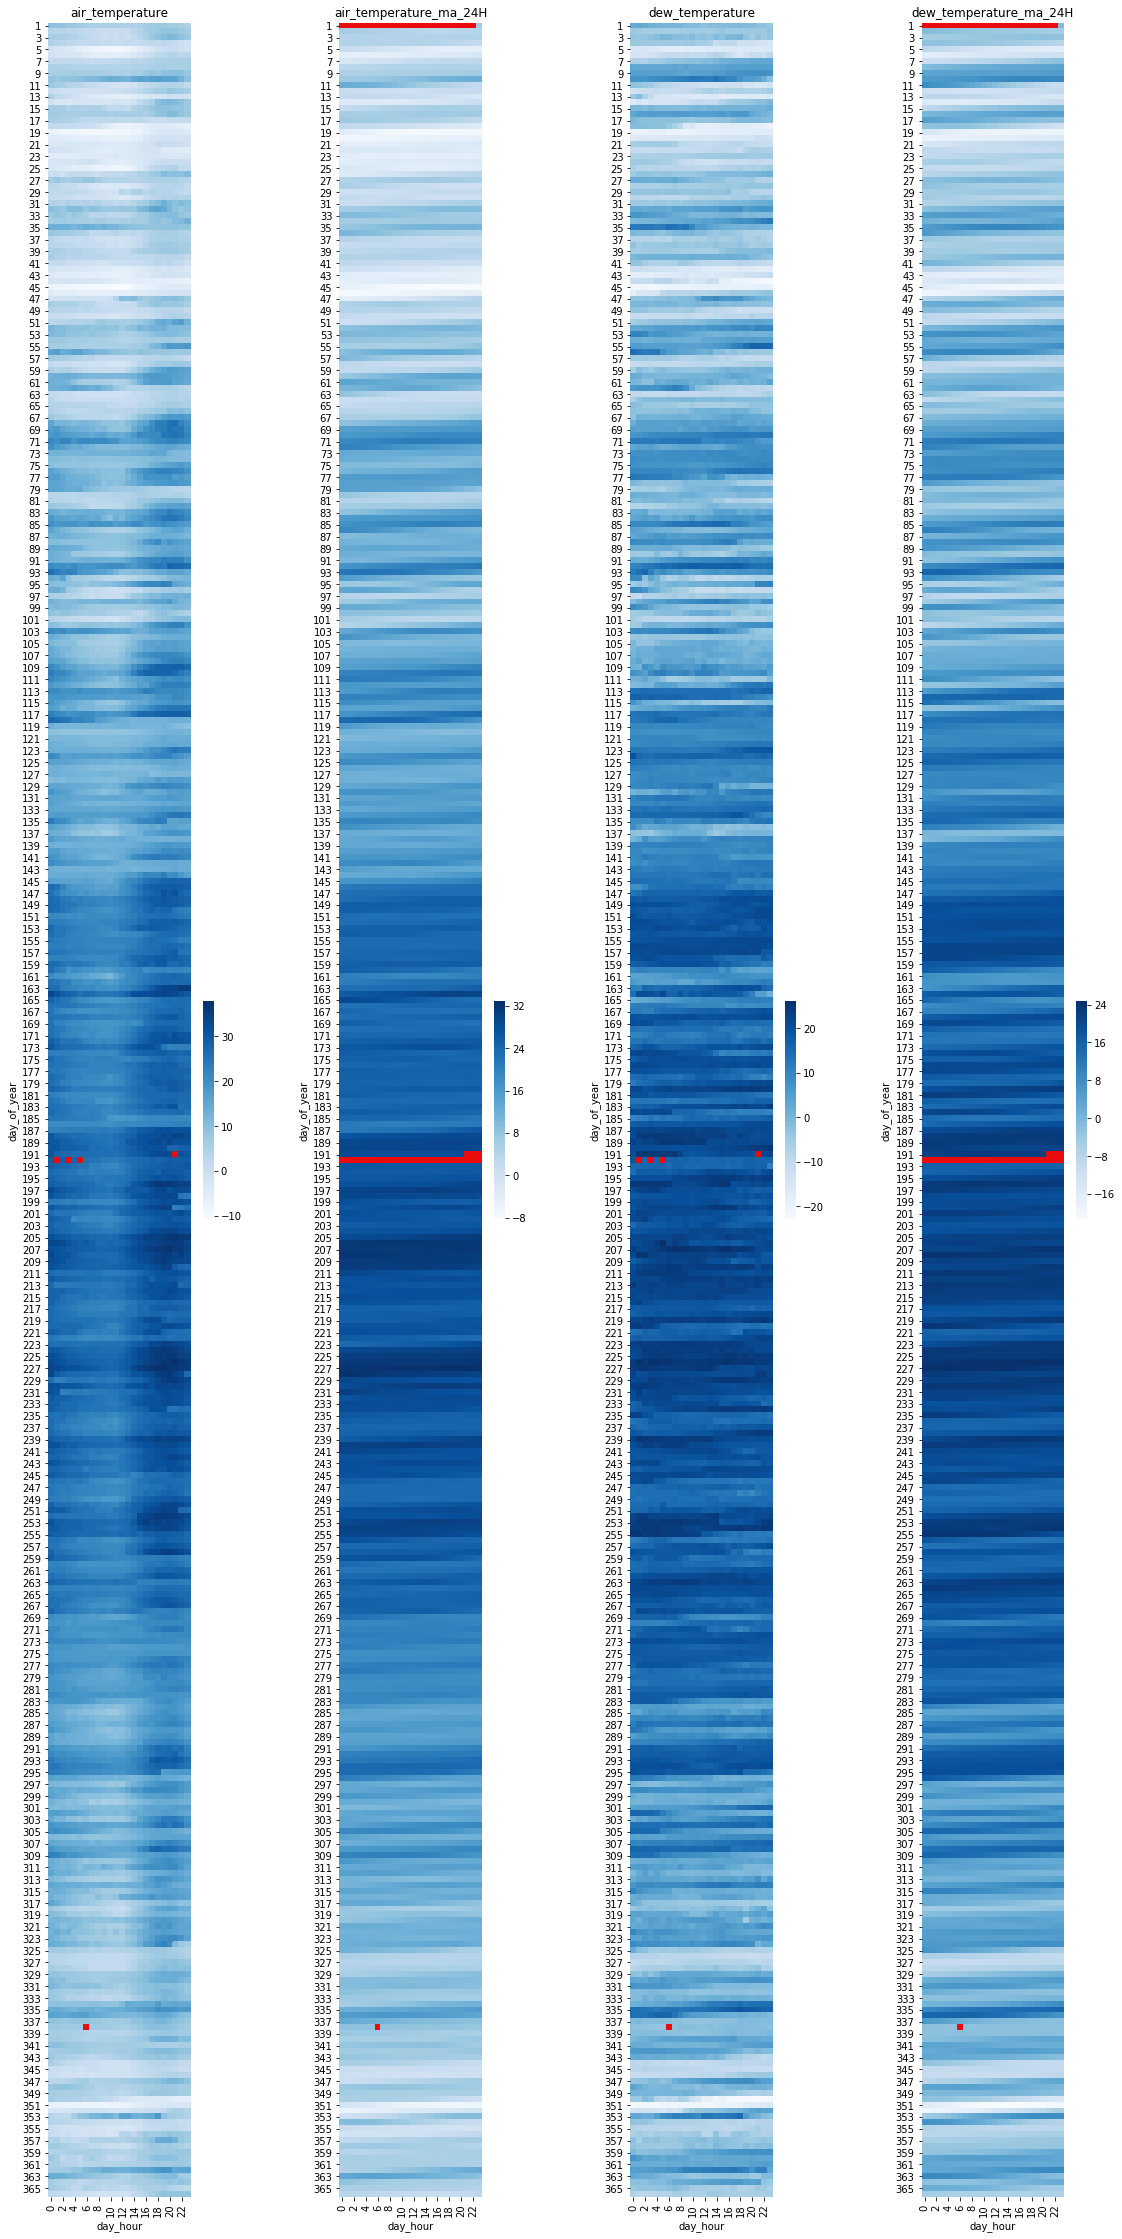

In [21]:
weather_features = [
    'air_temperature',
    'air_temperature_ma_24H',
    'dew_temperature',
    'dew_temperature_ma_24H'
]

pivot_and_plot(b_df_weather, weather_features)

Depending of wether the corresponding timestamp is present in the index before computing moving average features, any missing value in the raw data can generate a 24h missing gap in the averaging features. Then as any row with missing value in any used feature is deleted, it's great loss of data. We just have to interpolate the missing data to avoid those gaps.<br>
<br>
A one hour gap can be interpolated without problems, but we see 2h gaps also, and we could have wider gaps.
So we need to set a limit to the wideness of the gaps we are going to interpolate.<br>
We could visualize such interpolation results on 'fake' missing data intervals to see the quality of this interpolation in function of the wideness of the gap.<br>
<br>
We also note that the computation of averaged features induce missing datas on the first 24 hours, which could be avoided by computing on less points in this case.

<b>Interpolation on raw features</b>

First, we compare different methods for interpolation, and we apply them on different length of consecutive missing values. The objetive is select an interpolation method and a max gap to fill, to clean raw features like 'air_temperature'.

Define all fonctions to perform computations

In [14]:
def build_interpolation_method_stg(method_stg, order):
    if order == None:
        return method_stg
    else:
        return method_stg + '_' + str(order)

In [15]:
def compute_steps_to_cache(n_steps, margin, w_len, n_cons_missing):
    steps_to_cache = []
    for t in range(margin, n_steps-margin-n_cons_missing+1):
        if (t-margin)%w_len == 0:
            steps_to_cache.append(t)
    return steps_to_cache

In [16]:
"""
margin: the number of values that we don't interpolate at each extremity
w_len: move window with n_consecutive_missings missing points at each step from w_len points.
Error is still computed on all points.
"""
def perform_interpolation(
    df, 
    col_name, 
    timestamps, 
    margin, 
    w_len, 
    n_consecutive_missings, 
    interp_method, 
    order
):
    
    interp_method_stg = build_interpolation_method_stg(interp_method, order)
    print('perform interpolation : {}'.format(interp_method_stg))
    
    df_interp_air_T_m = pd.DataFrame({
        'timestamp' : timestamps[margin:-margin],
        col_name : df.loc[timestamps[margin:-margin], col_name].tolist(),
        'kind' : 'interpolation'
    })
    
    df_interp_air_T_m['interpolation_method'] = interp_method_stg
    
    interp_values = []
    interp_errors = []
    
    # Compute steps at wich we need to save interpolated values for future plotting
    steps_to_cache = compute_steps_to_cache(len(timestamps), margin, w_len, n_consecutive_missings)
    
    for t in range(margin, len(timestamps)-margin):
        
        timestamp = timestamps[t]
        
        # prepare interpolation
        
        df_to_interpolate = df.copy()
        
        missings_t = []
        for t_k in range(t, t+n_consecutive_missings):
            missings_t.append(t_k)
        
        for t_k in missings_t:
            df_to_interpolate.loc[timestamps[t_k], col_name] = np.nan
        
        # perform interpolation
        
        if order != None:
            df_to_interpolate[col_name].interpolate(
                method=interp_method, 
                order=order, 
                inplace=True
            )
        else:
            df_to_interpolate[col_name].interpolate(
                method=interp_method, 
                inplace=True
            )
            
        # compute and save metrics
        
        error = 0.
        do_cache = t in steps_to_cache
        
        for t_k in missings_t:

            interpolated_value = df_to_interpolate.loc[timestamps[t_k], col_name]
            truth = df.loc[timestamps[t_k], col_name]

            if do_cache:
                df_interp_air_T_m.loc[t_k, col_name] = interpolated_value
                
            error += np.abs(interpolated_value-truth)
            
        error /= len(missings_t)
        
        interp_errors.append(error)
        
    df_interp_air_T_m['interpolation_error'] = interp_errors 

    print('{} done.'.format(interp_method_stg))
    
    return df_interp_air_T_m    

In [24]:
"""
Fonctions to perform interpolation with different methods from pandas.Series.interpolate
on the same time serie.

Returns a dataframe containing interpolated values and interpolation error for each 
interpolation method.

n_cons_missings: number of consecutive missing values to interpolate.
margin: the number of values that we don't interpolate at each extremity.
w_len: move window with n_consecutive_missings missing points at each step from w_len points.
"""
def interpolate_with_multiple_methods(
    df,
    col_name,
    interp_methods,
    start_date, 
    end_date,
    margin,
    w_len,
    n_cons_missings
):

    truth_values_df = df.loc[start_date : end_date].copy()
    truth_values_df.reset_index(inplace=True)
    truth_values_df['interpolation_error'] = 0.
    truth_values_df['interpolation_method'] = 'ground_truth'
    truth_values_df['kind'] = 'truth'

    interp_tsps = truth_values_df['timestamp']

    interpolation_dfs = [truth_values_df]

    for (interp_method, interp_orders) in interp_methods.items():

        if interp_orders != None:
            for order in interp_orders:
                df_itpted = perform_interpolation(
                    df_air_T, 
                    col_name, 
                    interp_tsps, 
                    margin,
                    w_len,
                    n_cons_missings,
                    interp_method, 
                    order
                )
                interpolation_dfs.append(df_itpted)

        else:
            df_itpted = perform_interpolation(
                df_air_T, 
                col_name, 
                interp_tsps, 
                margin,
                w_len,
                n_cons_missings,
                interp_method, 
                None
            )
            interpolation_dfs.append(df_itpted)    

    return pd.concat(interpolation_dfs, sort=True)

In [36]:
def compute_and_sort_mean_interpolation_errors(df_interpolated):
    
    df_no_gt = df_interpolated[df_interpolated['interpolation_method'] != 'ground_truth']

    df_grouped_mean = df_no_gt.groupby('interpolation_method').mean().sort_values(by='interpolation_error')
    df_grouped_mean.rename({'interpolation_error':'mean_interpolation_error'}, inplace=True, axis=1)
    
    return df_grouped_mean

In [53]:
def plot_error_distributions(df_interpolated, methods_to_plot='all'):

    # Define which interpolation methods to plot.
    if methods_to_plot=='all':
        methods_to_plot = df_interpolated['interpolation_method'].unique().tolist()
        
    df_no_gt = df_interpolated[df_interpolated['interpolation_method'].isin(methods_to_plot)]

    with sns.axes_style("whitegrid"):
        g = sns.FacetGrid(df_no_gt, row='interpolation_method', height=2, aspect=3)
        g.map(sns.distplot, 'interpolation_error');

In [54]:
"""
max_length : max number of hours to plot.
"""
def plot_interpolations(df, col_name, max_length, methods_to_plot='all', figsize=(26,10)):
    fig = plt.figure(figsize=figsize)
    
    # Define which interpolation methods to plot.
    if methods_to_plot=='all':
        methods_to_plot = df['interpolation_method'].unique().tolist()
    else:
        methods_to_plot = ['ground_truth'] + methods_to_plot

    max_date = df['timestamp'].min() + pd.Timedelta('' + str(max_length) + ' hour')
    capped_df = df[df['timestamp'] < max_date]
    data = capped_df[capped_df['interpolation_method'].isin(methods_to_plot)]

    with sns.axes_style("whitegrid"):
        ax = sns.lineplot(
            x='timestamp', 
            y=col_name,
            hue='interpolation_method',
            size='kind',
            data=data
        )
        ax.xaxis.set_major_locator(mdates.DayLocator())

    plt.tight_layout(pad=0., w_pad=0., h_pad=2.)

Let's work on air_temperature, april 1 to 20.<br>

In [18]:
df_air_T = b_df_weather[['air_temperature']].copy()

<b>1. One successive missing value.</b>

In [19]:
# parameters
interp_methods = {
    'linear' : None,
    'quadratic' : None,
    'polynomial' : [3, 5],
    'nearest' : None,
    'spline' : [3, 4, 5],
}

start_date = '2016-04-01'
end_date = '2016-04-20'

margin = 5
w_len = 1
n_cons_missings = 1

df_interp_air_T = interpolate_with_multiple_methods(
    df_air_T,
    'air_temperature',
    interp_methods,
    start_date,
    end_date,
    margin,
    w_len,
    n_cons_missings
)

perform interpolation : linear
linear done.
perform interpolation : quadratic
quadratic done.
perform interpolation : polynomial_3
polynomial_3 done.
perform interpolation : polynomial_5
polynomial_5 done.
perform interpolation : nearest
nearest done.
perform interpolation : spline_3
spline_3 done.
perform interpolation : spline_4
spline_4 done.
perform interpolation : spline_5
spline_5 done.


In [20]:
df_interp_air_T.tail()

,air_temperature,interpolation_error,interpolation_method,kind,timestamp
470,15.331119,0.268881,spline_5,interpolation,2016-04-20 14:00:00
471,16.581789,0.118211,spline_5,interpolation,2016-04-20 15:00:00
472,17.787754,0.012246,spline_5,interpolation,2016-04-20 16:00:00
473,18.931277,0.631277,spline_5,interpolation,2016-04-20 17:00:00
474,19.778598,0.378598,spline_5,interpolation,2016-04-20 18:00:00


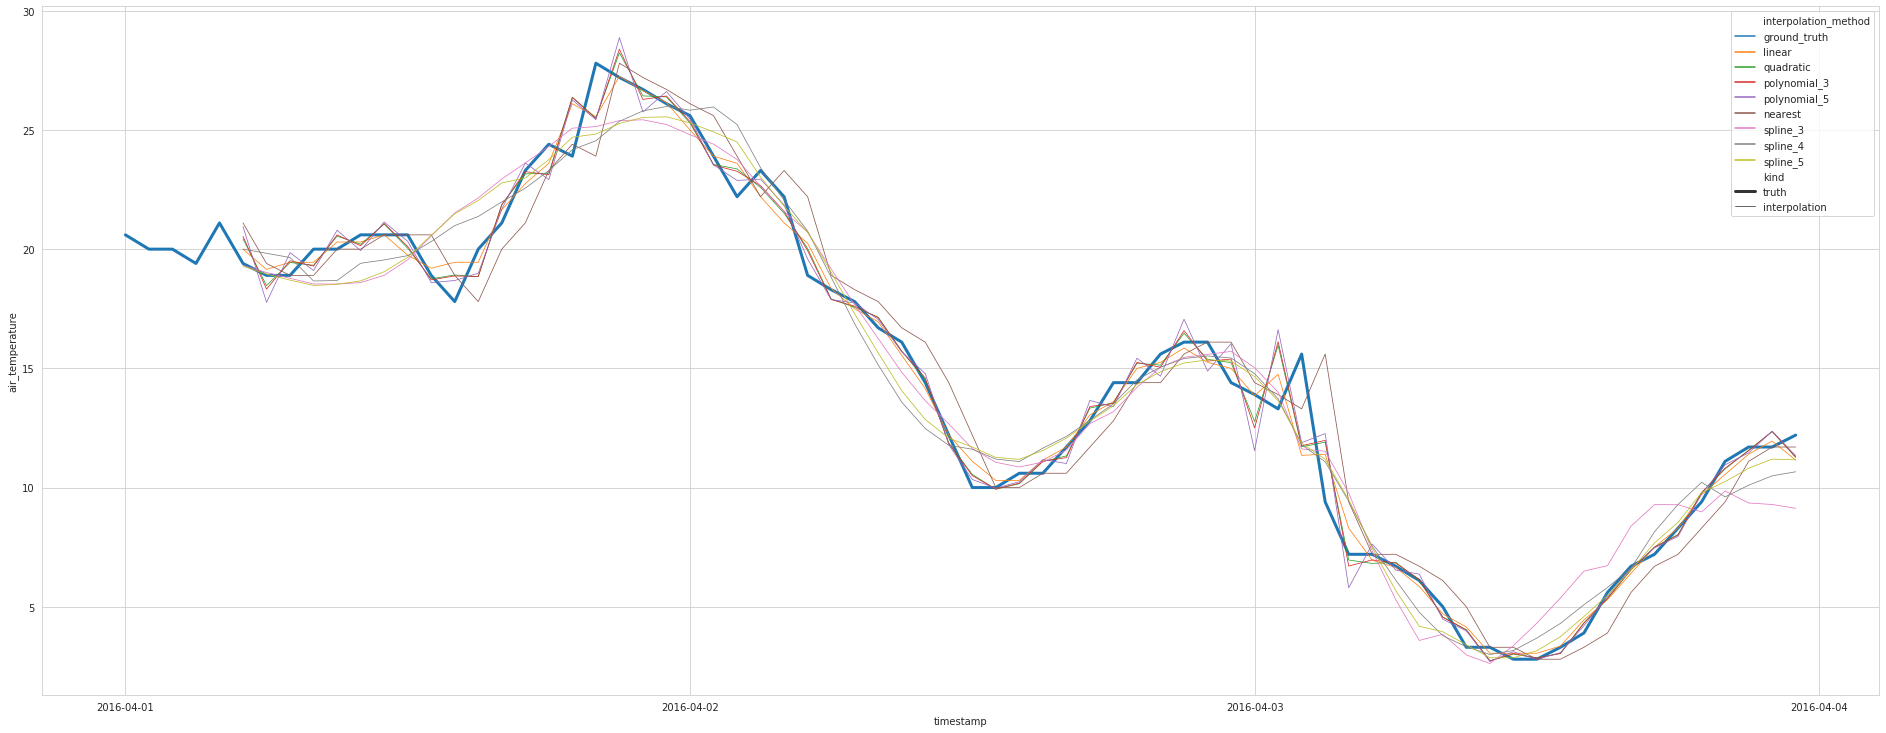

In [43]:
plot_interpolations(df_interp_air_T, 'air_temperature', 72)

In [48]:
mean_interp_errors = compute_and_sort_mean_interpolation_errors(df_interp_air_T)
top_interp_methods = mean_interp_errors.index[0:3].tolist()

mean_interp_errors

,air_temperature,mean_interpolation_error
interpolation_method,,
linear,12.566489,0.458191
quadratic,12.565736,0.474751
polynomial_3,12.565764,0.490523
polynomial_5,12.565911,0.582980
spline_5,12.556521,0.892065
spline_4,12.552660,0.946345
spline_3,12.564448,0.948292
nearest,12.567021,0.990000


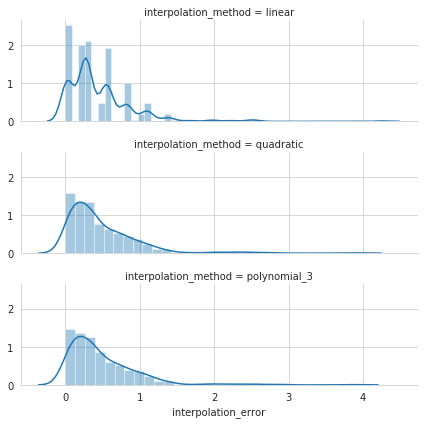

In [52]:
plot_error_distributions(df_interp_air_T, top_interp_methods)

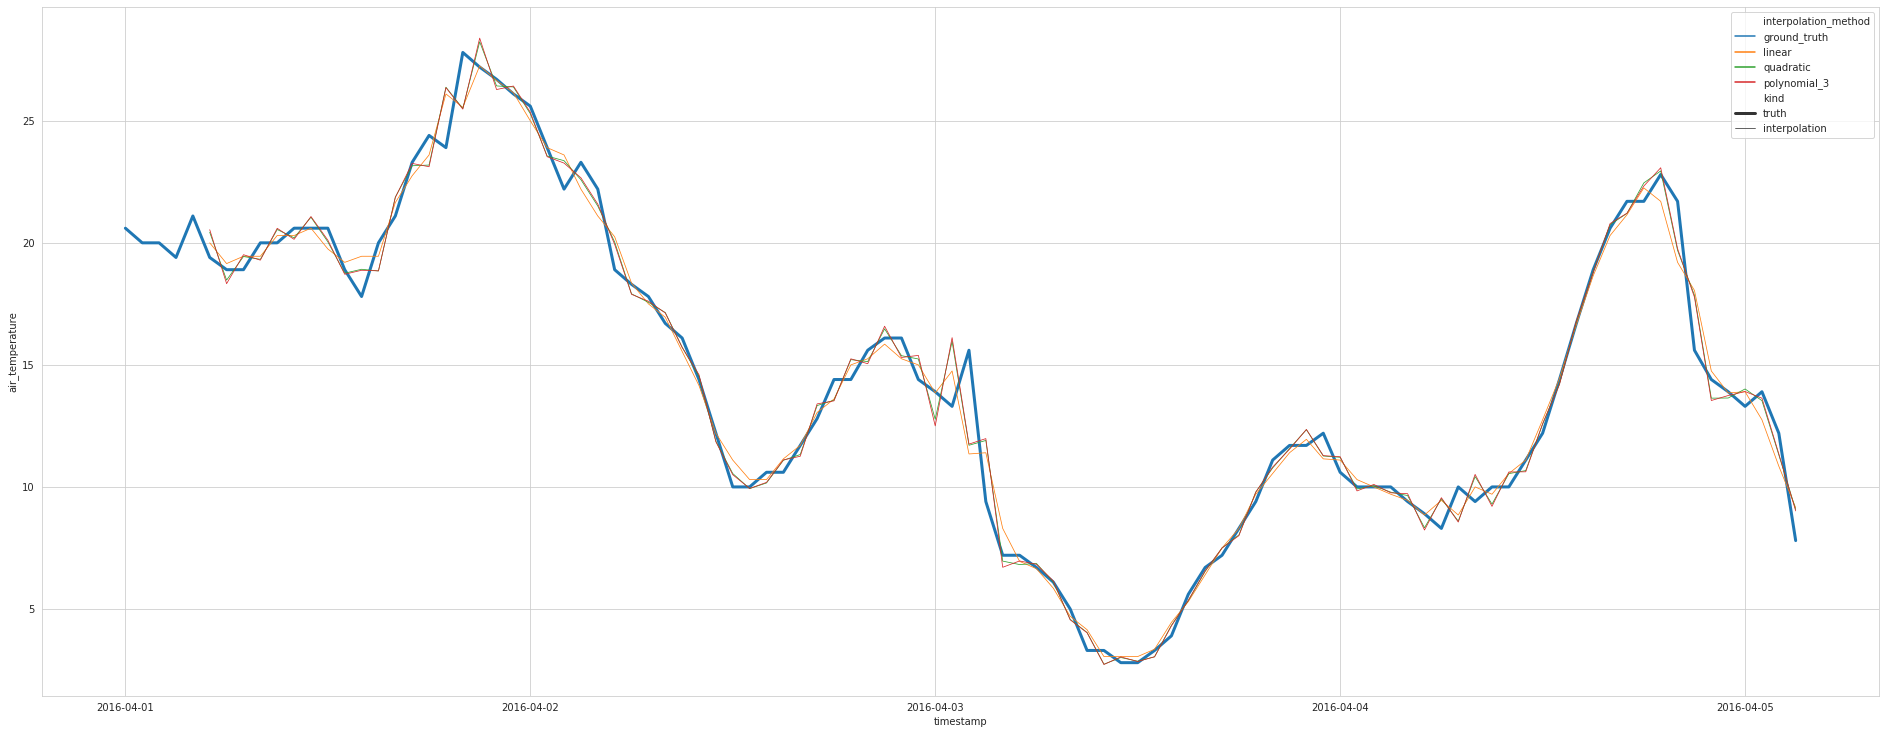

In [33]:
plot_interpolations(df_interp_air_T, 'air_temperature', 100, methods_to_plot=top_interp_methods)

<u>Conclusion :</u><br>For 1 consecutive missing value, linear interpolation performs best.<br>
Let's try for more missing values

<b>2. Two successive missings values.</b>

In [56]:
# parameters
interp_methods = {
    #'time' : None,
    'linear' : None,
    'quadratic' : None,
    'polynomial' : [3, 5],
    'nearest' : None,
    'spline' : [3, 4, 5],
}

start_date = '2016-04-01'
end_date = '2016-04-20'

margin = 5
w_len = 4
n_cons_missings = 2

# ----
# computations

df_interp_air_T = interpolate_with_multiple_methods(
    df_air_T,
    'air_temperature',
    interp_methods,
    start_date,
    end_date,
    margin,
    w_len,
    n_cons_missings
)

perform interpolation : linear
linear done.
perform interpolation : quadratic
quadratic done.
perform interpolation : polynomial_3
polynomial_3 done.
perform interpolation : polynomial_5
polynomial_5 done.
perform interpolation : nearest
nearest done.
perform interpolation : spline_3
spline_3 done.
perform interpolation : spline_4
spline_4 done.
perform interpolation : spline_5
spline_5 done.


In [57]:
mean_interp_errors = compute_and_sort_mean_interpolation_errors(df_interp_air_T)
top_interp_methods = mean_interp_errors.index[0:3].tolist()

mean_interp_errors

,air_temperature,mean_interpolation_error
interpolation_method,,
linear,12.533404,0.586667
quadratic,12.540527,0.604076
polynomial_3,12.543668,0.610867
polynomial_5,12.559879,0.768003
nearest,12.533404,0.989574
spline_5,12.535882,0.997320
spline_4,12.532590,1.038672
spline_3,12.547529,1.112496


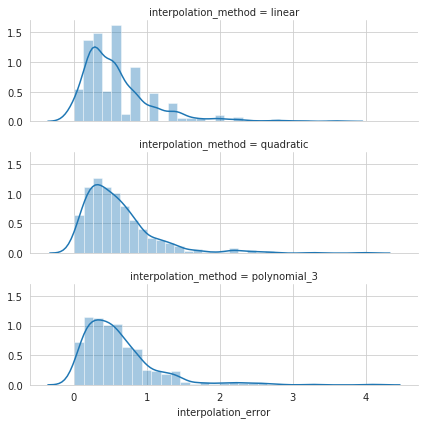

In [58]:
plot_error_distributions(df_interp_air_T, top_interp_methods)

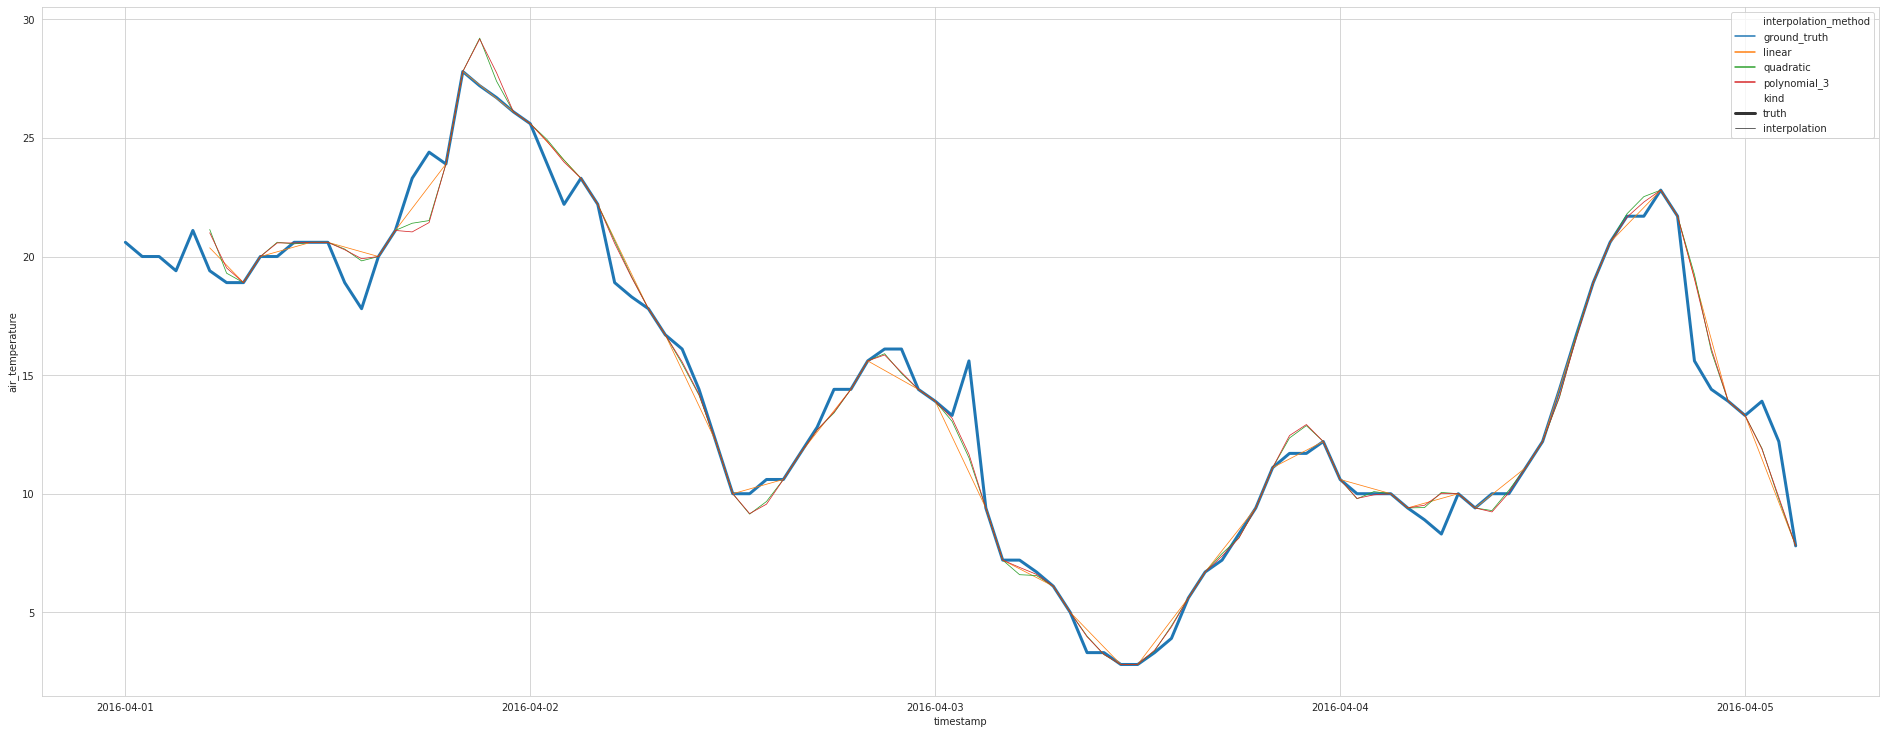

In [60]:
plot_interpolations(df_interp_air_T, 'air_temperature', 100, methods_to_plot=top_interp_methods)

<u>Conclusion :</u><br>For 2 consecutive missing values, linear interpolation still performs best.<br>
Most interpolation errors are between 0 and 1~1.5 degrees.<br>
Let's see for 3 consecutive missing values

<b>3. Three successive missings values.</b>

In [61]:
# parameters
interp_methods = {
    #'time' : None,
    'linear' : None,
    'quadratic' : None,
    'polynomial' : [3, 5],
    'nearest' : None,
    'spline' : [3, 4, 5],
}

start_date = '2016-04-01'
end_date = '2016-04-20'

margin = 5
w_len = 5
n_cons_missings = 3

# ----
# computations

df_interp_air_T = interpolate_with_multiple_methods(
    df_air_T,
    'air_temperature',
    interp_methods,
    start_date,
    end_date,
    margin,
    w_len,
    n_cons_missings
)

perform interpolation : linear
linear done.
perform interpolation : quadratic
quadratic done.
perform interpolation : polynomial_3
polynomial_3 done.
perform interpolation : polynomial_5
polynomial_5 done.
perform interpolation : nearest
nearest done.
perform interpolation : spline_3
spline_3 done.
perform interpolation : spline_4
spline_4 done.
perform interpolation : spline_5
spline_5 done.


In [62]:
mean_interp_errors = compute_and_sort_mean_interpolation_errors(df_interp_air_T)
top_interp_methods = mean_interp_errors.index[0:3].tolist()

mean_interp_errors

,air_temperature,mean_interpolation_error
interpolation_method,,
linear,12.537340,0.726950
quadratic,12.545183,0.750394
polynomial_3,12.550416,0.776849
spline_5,12.539655,1.092863
polynomial_5,12.590411,1.137999
spline_4,12.525354,1.169170
spline_3,12.549400,1.193443
nearest,12.550213,1.253830


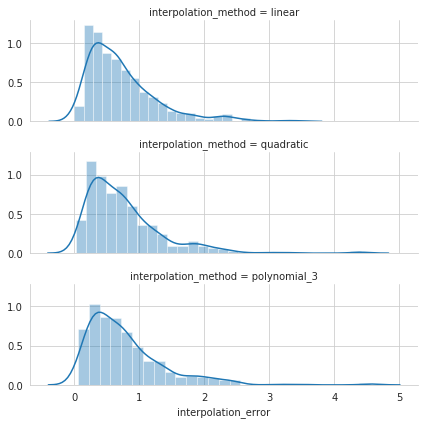

In [63]:
plot_error_distributions(df_interp_air_T, top_interp_methods)

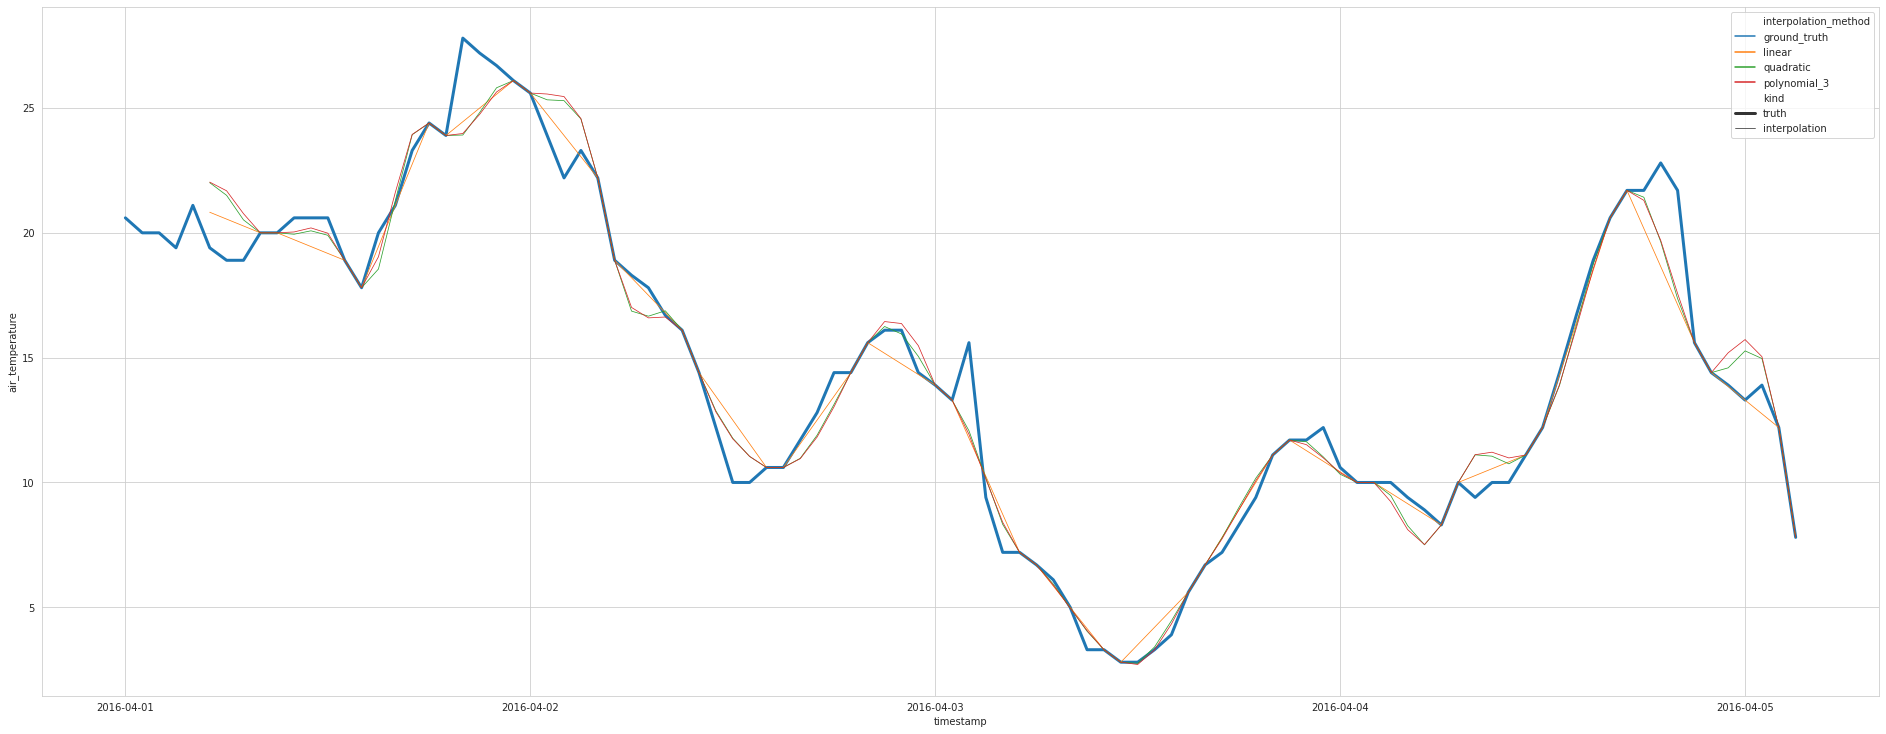

In [64]:
plot_interpolations(df_interp_air_T, 'air_temperature', 100, methods_to_plot=top_interp_methods)

<u>Conclusion :</u><br>For 3 consecutive missing values, linearis slightly better.<br>
We observe that when 'peaks' are cut, quadratic is better, but linear deals best with the irregularities (noise) of the curve.
Most interpolation errors are between 0 and 1.5~2 degrees.<br>
This looks still ok, but maybe it's best to limit ourselves to three consecutive values interpolations.<br>
Let's test 4.

<b>4. Four successive missings values.</b>

In [65]:
# parameters
interp_methods = {
    #'time' : None,
    'linear' : None,
    'quadratic' : None,
    'polynomial' : [3, 5],
    'nearest' : None,
    'spline' : [3, 4, 5],
}

start_date = '2016-04-01'
end_date = '2016-04-20'

margin = 5
w_len = 6
n_cons_missings = 4

# ----
# computations

df_interp_air_T = interpolate_with_multiple_methods(
    df_air_T,
    'air_temperature',
    interp_methods,
    start_date,
    end_date,
    margin,
    w_len,
    n_cons_missings
)

perform interpolation : linear
linear done.
perform interpolation : quadratic
quadratic done.
perform interpolation : polynomial_3
polynomial_3 done.
perform interpolation : polynomial_5
polynomial_5 done.
perform interpolation : nearest
nearest done.
perform interpolation : spline_3
spline_3 done.
perform interpolation : spline_4
spline_4 done.
perform interpolation : spline_5
spline_5 done.


In [66]:
mean_interp_errors = compute_and_sort_mean_interpolation_errors(df_interp_air_T)
top_interp_methods = mean_interp_errors.index[0:3].tolist()

mean_interp_errors

,air_temperature,mean_interpolation_error
interpolation_method,,
quadratic,12.609767,0.859922
linear,12.605532,0.874266
polynomial_3,12.612453,0.880443
spline_5,12.589855,1.206831
spline_4,12.553858,1.291530
spline_3,12.579480,1.332314
polynomial_5,12.639184,1.369596
nearest,12.605532,1.384202


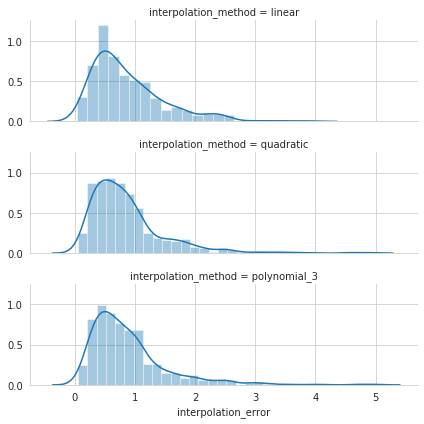

In [67]:
plot_error_distributions(df_interp_air_T, top_interp_methods)

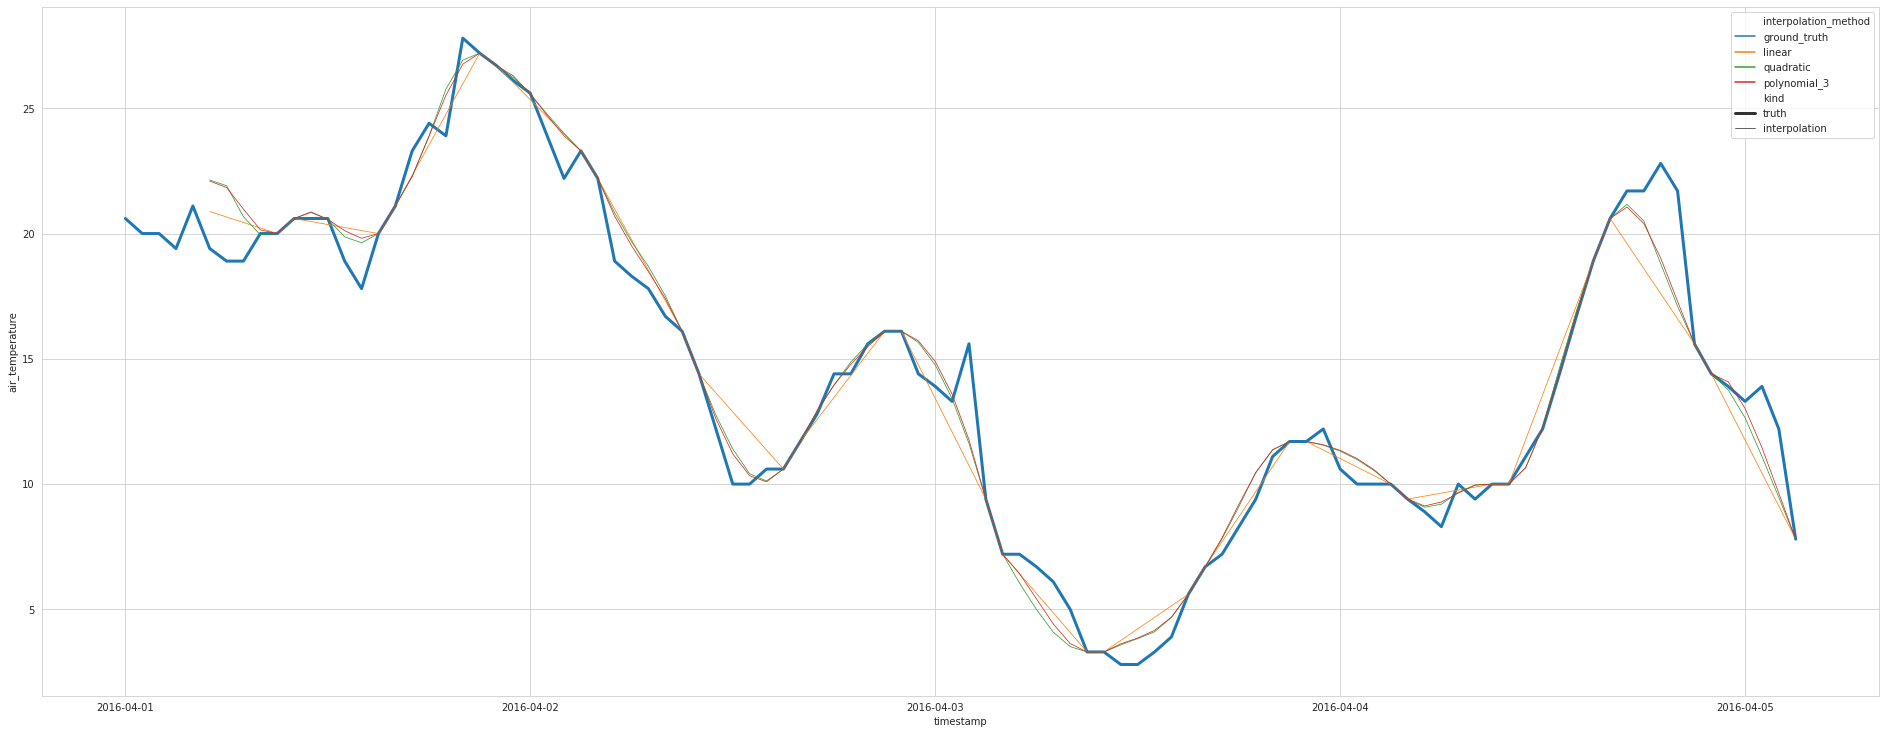

In [68]:
plot_interpolations(df_interp_air_T, 'air_temperature', 100, methods_to_plot=top_interp_methods)

<u>Conclusion :</u><br>For 4 consecutive missing values, quadratic becomes slightly better.<br>
We observe that when 'peaks' are cut, quadratic is better, but linear deals best with the irregularities (noise) of the curve.<br>
Interpolation error is becoming higher, maybe too hight to add interpolated data to the train set.

<b>5. Sequence of alternating missing/non missing.</b><br>
TODO

<b>6. Conclusion and application</b><br>
<br>
We choose a linear interpolation and we limit interpolation to 3 consecutive missing values.<br>
We apply it before computing averaged features in order to avoid missing values when averaging.

In [55]:
# Loads weather data
raw_df_weather = pd.read_csv(data_folder_path + 'weather_train.csv', 
                 parse_dates=['timestamp'], index_col=['site_id', 'timestamp'])

b_df_weather = raw_df_weather.loc[(this_site,)]

# keep only air_temperature and dew_temperature
b_df_weather.drop(
    ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'cloud_coverage'],
    axis=1,
    inplace=True
)

# Clean timestamps index.
clean_index = pd.date_range(start=b_df_weather.index.min(), end=b_df_weather.index.max(), freq='H')
b_df_weather = b_df_weather.reindex(index=clean_index, copy=True)


# Interpolate missing values.
b_df_weather.interpolate(method='linear', limit=3, inplace=True)

# Build time features
b_df_weather['day_hour'] = b_df_weather.index.to_series().dt.hour
b_df_weather['day_of_year'] = b_df_weather.index.to_series().dt.dayofyear

# Builds averaged weather features.

timeframes = [24]
features_to_avg = ['air_temperature', 'dew_temperature']
do_center = False



for c in features_to_avg:
    ts = b_df_weather[c]
    for timeframe in timeframes:
        shifted_ts = ts.rolling(timeframe, center=do_center).mean()
        new_col_name = '' + c + '_ma_' + str(timeframe) + 'H'
        b_df_weather[new_col_name] = shifted_ts

b_df_weather.head()


,air_temperature,dew_temperature,day_hour,day_of_year,air_temperature_ma_24H,dew_temperature_ma_24H
2016-01-01 00:00:00,10.0,2.2,0,1,NaN,NaN
2016-01-01 01:00:00,9.4,2.8,1,1,NaN,NaN
2016-01-01 02:00:00,8.9,2.2,2,1,NaN,NaN
2016-01-01 03:00:00,7.8,1.1,3,1,NaN,NaN
2016-01-01 04:00:00,7.8,0.6,4,1,NaN,NaN


Let's see the data after performing interpolation.

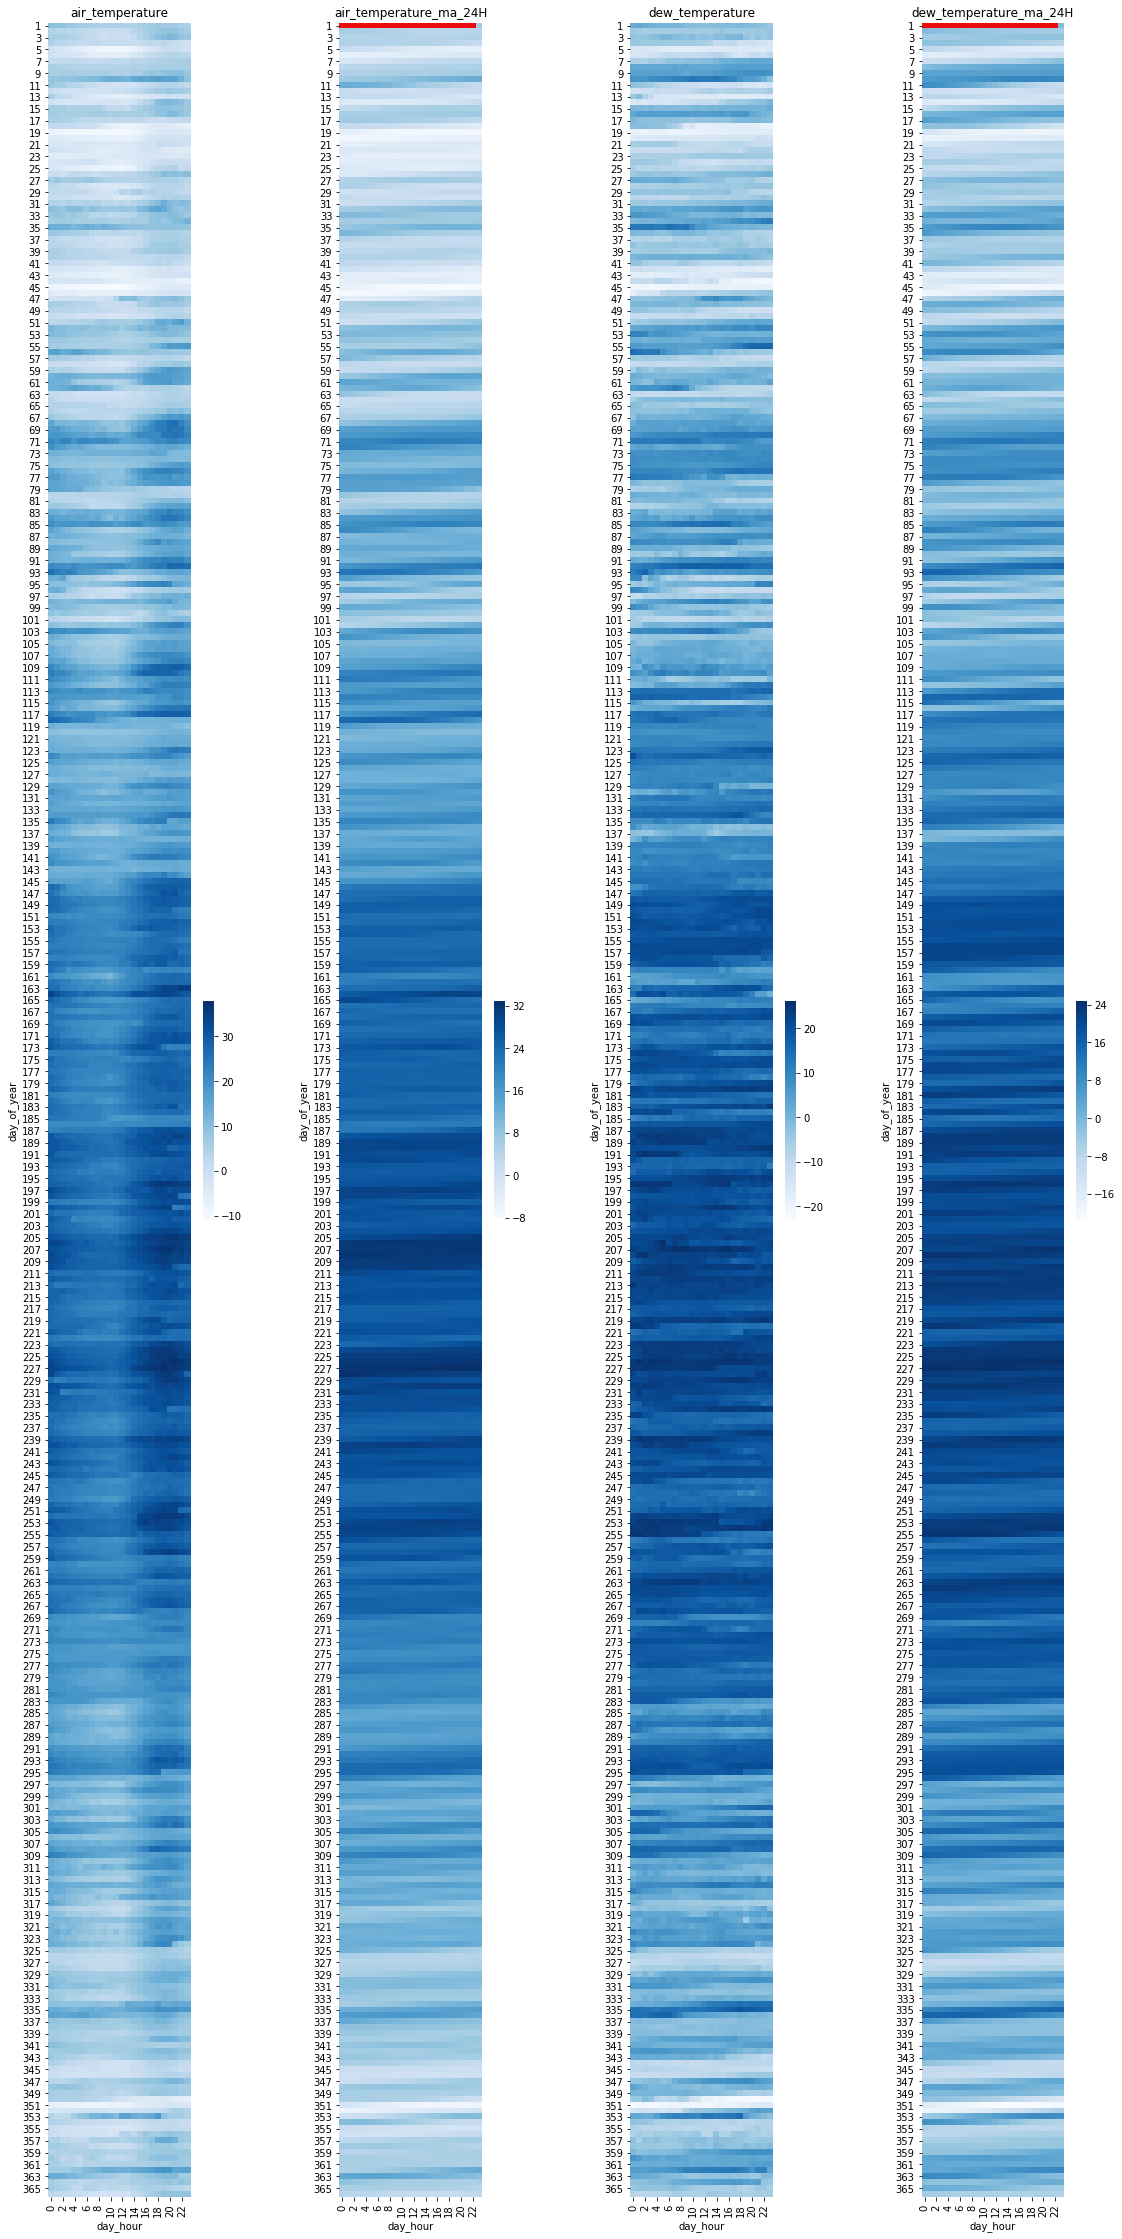

In [57]:
weather_features = [
    'air_temperature',
    'air_temperature_ma_24H',
    'dew_temperature',
    'dew_temperature_ma_24H'
]

pivot_and_plot(b_df_weather, weather_features)

We still nead to handle missing values when computing moving averages features at the begining of the timeseries.

<b>Missing values when computing moving averages.<b>

In [100]:
start = '2016-01-02 00:00:00'
end = '2016-01-10 00:00:00'

entry_data = b_df_weather['air_temperature'].loc[start:end]
air_temperature_data_df = b_df_weather.loc[:end, ['air_temperature']].copy()
air_temperature_data_df.rename({'air_temperature':'temperature'}, inplace=True, axis=1)
air_temperature_data_df['name'] = 'air_temperature'

In [101]:
ma_full_df = b_df_weather.loc[start:end, ['air_temperature_ma_24H']].copy()
ma_full_df.rename({'air_temperature_ma_24H':'temperature'}, inplace=True, axis=1)
ma_full_df['name'] = 'true_air_temperature_ma_24H'

In [102]:
ma_no_min_period = entry_data.rolling(24, min_periods=1, center=False).mean()
ma_no_min_period_df = pd.DataFrame({'temperature' : ma_no_min_period, 'name' : 'computed_air_temperature_ma_24H'})

In [103]:
all_temperatures = pd.concat([air_temperature_data_df, ma_full_df, ma_no_min_period_df])

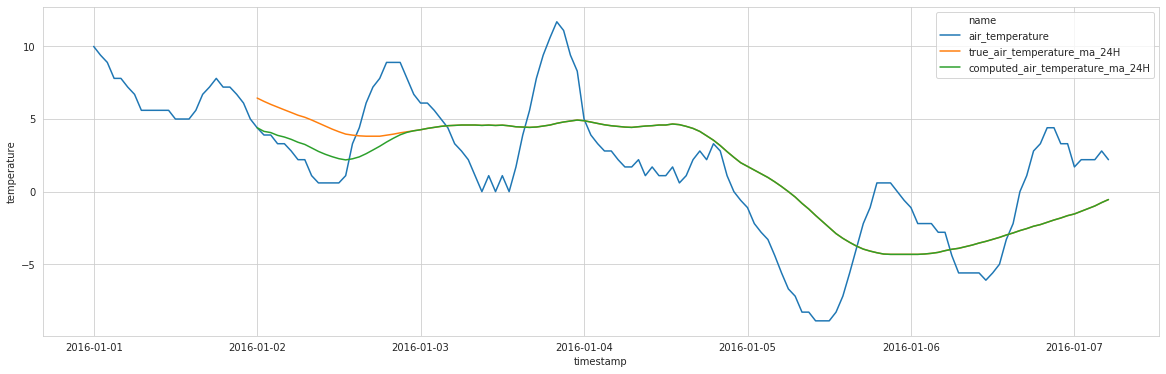

In [105]:
fig = plt.figure(figsize=(16,5))

max_length = 150

data = all_temperatures.reset_index(inplace=False).rename({'index':'timestamp'}, inplace=False, axis=1)

max_date = data['timestamp'].min() + pd.Timedelta('' + str(max_length) + ' hour')
capped_data = data[data['timestamp'] < max_date]

with sns.axes_style("whitegrid"):
    ax = sns.lineplot(
        x='timestamp', 
        y='temperature',
        hue='name',
        data=capped_data
    )
    ax.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout(pad=0., w_pad=0., h_pad=2.)

This is not a good method because it induces a lag in MA. For the moment, we are just going to not use those first 24H values.